In [1]:
%load_ext autoreload
%autoreload 2

import config
from tools import dataloader, preprocess

In [2]:
import os
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import torch
from torchvision import transforms, utils, datasets
from IPython import display

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


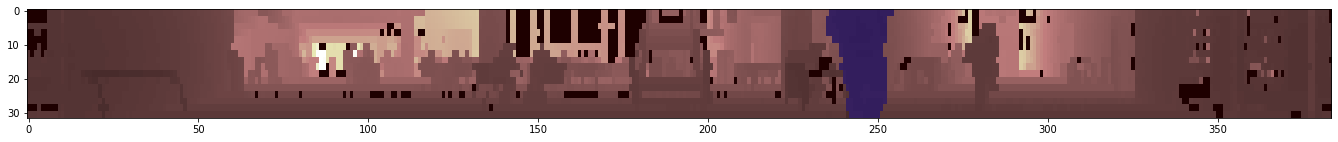

In [3]:
loader = dataloader.batch_loader(root_dir="data/train.csv", augmentation=None)
for idx in range(400, 700, 10):
    p, n, mask, y = loader[idx]
    plt.show()
    plt.figure(figsize=(24, 2))
    plt.imshow(np.repeat(p[-1, 0, :, :], 2, axis=0), cmap='pink')
    plt.imshow(np.repeat(y, 2, axis=0), cmap=ListedColormap([[0., 0., 0., 0.], [0., 0., 1, 0.25]]))
    plt.show()
    break

In [4]:
train_loader = dataloader.batch_loader(root_dir="data/synthetic_train.csv", augmentation=config.augmentation)
val_loader = dataloader.batch_loader(root_dir="data/synthetic_test.csv", augmentation=config.augmentation)

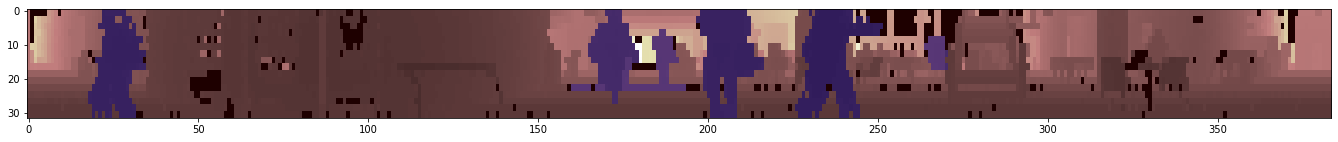

In [5]:
for idx in range(0, 2000, 10):
    p, n, mask, y = train_loader[idx]
    plt.figure(figsize=(24, 2))
    plt.imshow(np.repeat(p[-1, 0, :, :], 2, axis=0), cmap='pink')
    plt.imshow(np.repeat(y, 2, axis=0), cmap=ListedColormap([[0., 0., 0., 0.], [0., 0., 1., 0.25]]))
#     plt.title("idx: %d, %s" % (idx, train_loader.landmarks_frame.iloc[270, 0]))
    plt.show()
    break

In [6]:
%load_ext autoreload
%autoreload 2

# from model import SegNet as models
from model import Unet as models

# model = models.SegNet(1, 1).to(device)
model = models.ResNetUNet(1).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.5))
optimizer = optim.Adam(model.parameters(), lr=0.001)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
p, n, mask, y = train_loader[idx]
print(p.shape, n.shape)
y_pred = model(p[0:4,...].unsqueeze(0).to(device), n[0:3,...].unsqueeze(0).to(device))
print(y_pred)

torch.Size([4, 1, 16, 384]) torch.Size([4, 8, 16, 384])
tensor([[[[0.1200, 0.1246, 0.1134,  ..., 0.1229, 0.1139, 0.1154],
          [0.1259, 0.1294, 0.1321,  ..., 0.1335, 0.1337, 0.1344],
          [0.1246, 0.1180, 0.1285,  ..., 0.1280, 0.1353, 0.1300],
          ...,
          [0.1310, 0.1193, 0.1245,  ..., 0.1246, 0.1081, 0.1057],
          [0.1301, 0.1201, 0.1245,  ..., 0.1267, 0.1040, 0.1040],
          [0.1223, 0.1176, 0.1110,  ..., 0.1136, 0.0949, 0.1126]]]],
       device='cuda:2', grad_fn=<CudnnConvolutionBackward>)


In [8]:
y_pred.min(), y_pred.max()

(tensor(0.0820, device='cuda:2', grad_fn=<MinBackward1>),
 tensor(0.2271, device='cuda:2', grad_fn=<MaxBackward1>))

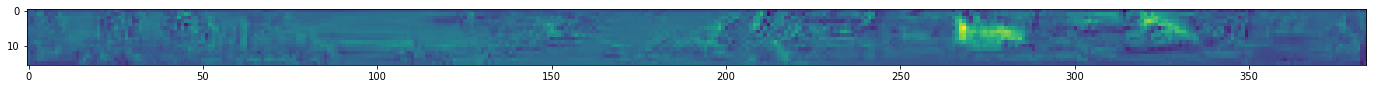

In [9]:
plt.figure(figsize=(24, 2))
plt.imshow(y_pred.cpu().detach()[0, 0, :, :].numpy())
plt.show()

In [10]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

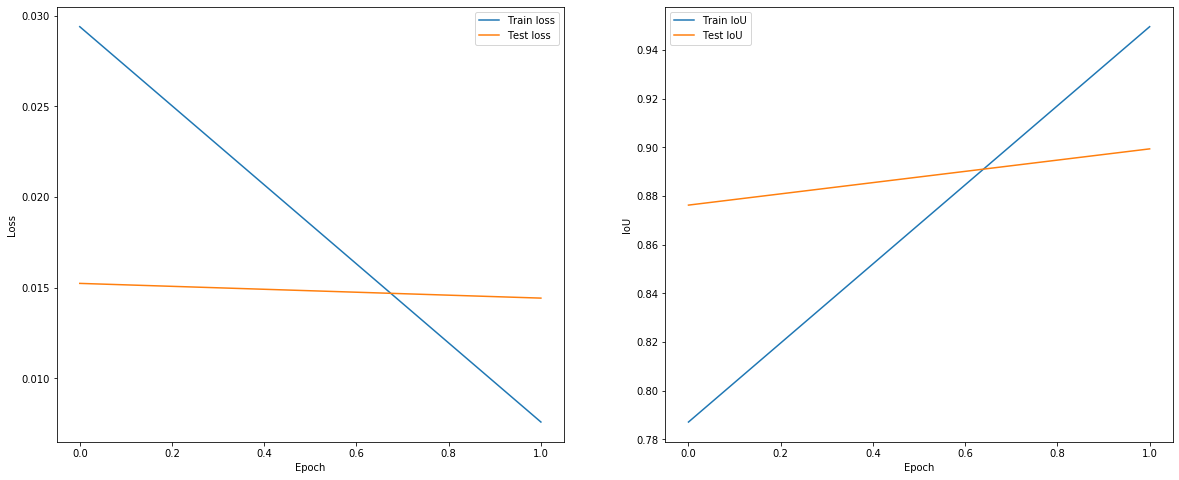

  0%|          | 0/625 [00:00<?, ?it/s]

Train loss 0.00759, Test loss: 0.0144
Train IoU   0.95, Test IoU:  0.899
Epoch  2: 

 76%|███████▌  | 476/625 [06:01<01:13,  2.04it/s]

In [ ]:
from tqdm import tqdm

def train(model, optimizer, criterion, batch_size=32, num_epochs=100, silent=False, model_name='UNet'):

    train_dataloader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True, num_workers=4)
    test_dataloader = torch.utils.data.DataLoader(val_loader, batch_size=batch_size, shuffle=False, num_workers=4)
  
    print("Train examples: {}".format(len(train_loader)))
    print("Validation examples: {}".format(len(val_loader)))
    print("Start training...")

    train_loss_plot = []
    test_loss_plot = []
    train_accur_plot = []
    test_accur_plot = []
#     try:
    for epoch in range(num_epochs):
        if (not silent):
            print("Epoch {:2}: ".format(epoch), end='')
        else:
            print('.', end='')

        # train one epoch
        model.train()
        total_train_loss = 0
        correct_examples_train = 0
        for batch_idx, data in enumerate(tqdm(train_dataloader)):
            p, n, mask, label = data
            p, n, label = p.to(device), n.to(device), label.to(device)

            optimizer.zero_grad()
            pred = model(p[:, 0:4,...], n[:, 0:3,...])
            loss = criterion(pred.view(pred.shape[0], -1),
                             label.view(label.shape[0], -1).float()) * batch_size

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            correct_examples_train += calc_iou(pred[:,0,:,:].cpu().detach().numpy(),
                                               label.squeeze(1).cpu().detach().numpy()) * batch_size
        model.eval()
        correct_examples_test = 0
        total_test_loss = 0
        for batch_idx, data in enumerate(test_dataloader):
            p, n, mask, label = data
            p, n, label = p.to(device), n.to(device), label.to(device)

            pred = model(p[:, 0:4,...], n[:, 0:3,...])
            loss = criterion(pred.view(pred.shape[0], -1),
                             label.view(label.shape[0], -1).float()) * batch_size
            total_test_loss += loss.item()
            correct_examples_test += calc_iou(pred[:,0,:,:].cpu().detach().numpy(),
                                              label.squeeze(1).cpu().detach().numpy()) * batch_size
            

        train_loss_plot.append(total_train_loss / len(train_loader))
        test_loss_plot.append(total_test_loss  / len(val_loader))
        
        train_accur_plot.append(correct_examples_train / len(train_loader))
        test_accur_plot.append(correct_examples_test / len(val_loader))

        if (not silent):
            display.clear_output(wait=True)
            plt.figure(figsize=(20, 8))
            plt.subplot(1,2,1)
            plt.plot(range(len(train_loss_plot)), train_loss_plot)
            plt.plot(range(len(test_loss_plot)), test_loss_plot)
            plt.legend(['Train loss', 'Test loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')

            plt.subplot(1,2,2)
            plt.plot(range(len(train_accur_plot)), train_accur_plot)
            plt.plot(range(len(test_accur_plot)), test_accur_plot)
            plt.legend(['Train IoU', 'Test IoU'])
            plt.xlabel('Epoch')
            plt.ylabel('IoU')
            plt.show()

            print('Train loss {:6.3}, Test loss: {:6.3}'\
                  .format(total_train_loss / len(train_loader), 
                          total_test_loss  / len(val_loader)))
            print('Train IoU {:6.3}, Test IoU: {:6.3}'\
                  .format(correct_examples_train / len(train_loader), 
                          correct_examples_test  / len(val_loader)))

        torch.save(model.state_dict(), model_name + '_best.pth')
train(model, optimizer, criterion, batch_size=16, num_epochs=10)

In [ ]:
MODEL_PATH = "UNet_best.pth"
#val_root = 'tiny-imagenet-200/val'

model = models.ResNetUNet(1).to(device)
if torch.cuda.is_available():
    model.to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))

In [ ]:
val_loader = dataloader.batch_loader(root_dir="data/synthetic_test.csv")
val_dataloader = torch.utils.data.DataLoader(val_loader, batch_size=1, shuffle=False)

In [ ]:
from tqdm import tqdm

total_test_IoU = 0
total_test_loss = 0
model.eval()

for batch_idx, data in enumerate(val_dataloader):
    p, n, mask, label = data
    p, n, label = p.to(device), n.to(device), label.to(device)
    
    pred = model(p[:, 0:4, ...], n[:, 0:3, ...])
    
    plt.figure(figsize=(24, 2))
    plt.imshow(np.repeat(p.cpu().detach()[0, -1, 0, :, :], 2, axis=0), cmap='pink')
    plt.imshow(np.repeat(pred.cpu().detach()[0, 0, :, :], 2, axis=0) > 0, cmap=ListedColormap([[0., 0., 0., 0.], [0., 0., 1., 0.25]]))
    plt.imshow(np.repeat(label.cpu().detach()[0, :, :], 2, axis=0), cmap=ListedColormap([[0., 0., 0., 0.], [0., 1., 0., 0.2]]))
    plt.show()
    
    loss = criterion(pred.view(pred.shape[0], -1),
                               label.view(label.shape[0], -1).float())
    total_test_loss += loss.item()

    IoU = calc_iou(pred[:,0,:,:].cpu().detach().numpy(),
                   label.squeeze(1).cpu().detach().numpy())
    total_test_IoU += IoU

val_loss = total_test_loss  / len(val_loader)
val_IoU = total_test_IoU / len(val_loader)
print("Validation loss: %.4f, Validation IoU: %.3f%%" % (val_loss, val_IoU))